In [51]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer

from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

In [52]:
def load_sentences(filepath):

    final = []
    sentences = []

    with open(filepath, 'r') as f:

        for line in f.readlines():

            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))

    return final

In [53]:
train_samples = load_sentences('/train.txt')
test_samples = load_sentences('/test.txt')
valid_samples = load_sentences('/valid.txt')

samples = train_samples + test_samples
schema = ['_'] + sorted({tag for sentence in samples
                             for _, tag in sentence})

In [54]:
from transformers import AutoConfig, TFAutoModelForTokenClassification

MODEL_NAME = 'bert-base-cased'

config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema))
model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME,
                                                          config=config)
model.summary()

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  107719680 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 107727370 (410.95 MB)
Trainable params: 107727370 (410.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_sample(sample):
    seq = [
               (subtoken, tag)
               for token, tag in sample
               for subtoken in tokenizer(token)['input_ids'][1:-1]
           ]
    return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples):
    tag_index = {tag: i for i, tag in enumerate(schema)}
    tokenized_samples = list(tqdm(map(tokenize_sample, samples)))
    max_len = max(map(len, tokenized_samples))
    X = np.zeros((len(samples), max_len), dtype=np.int32)
    y = np.zeros((len(samples), max_len), dtype=np.int32)
    for i, sentence in enumerate(tokenized_samples):
        for j, (subtoken_id, tag) in enumerate(sentence):
            X[i, j] = subtoken_id
            y[i,j] = tag_index[tag]
    return X, y

X_train, y_train = preprocess(train_samples)
X_test, y_test = preprocess(test_samples)
X_valid, y_valid = preprocess(valid_samples)

14041it [00:10, 1280.06it/s]
3453it [00:02, 1220.17it/s]
3250it [00:03, 949.91it/s]


In [56]:
y_valid.shape

(3250, 151)

In [57]:
#perform EDA on the train samples data
import seaborn as sns
import matplotlib.pyplot as plt

# Get the number of samples in the train dataset
num_samples = len(train_samples)

# Get the number of unique tags in the train dataset
unique_tags = set([tag for sentence in train_samples for _, tag in sentence])
num_unique_tags = len(unique_tags)

# Get the average number of tokens per sample in the train dataset
tokens_per_sample = [len(sentence) for sentence in train_samples]
avg_tokens_per_sample = sum(tokens_per_sample) / len(tokens_per_sample)

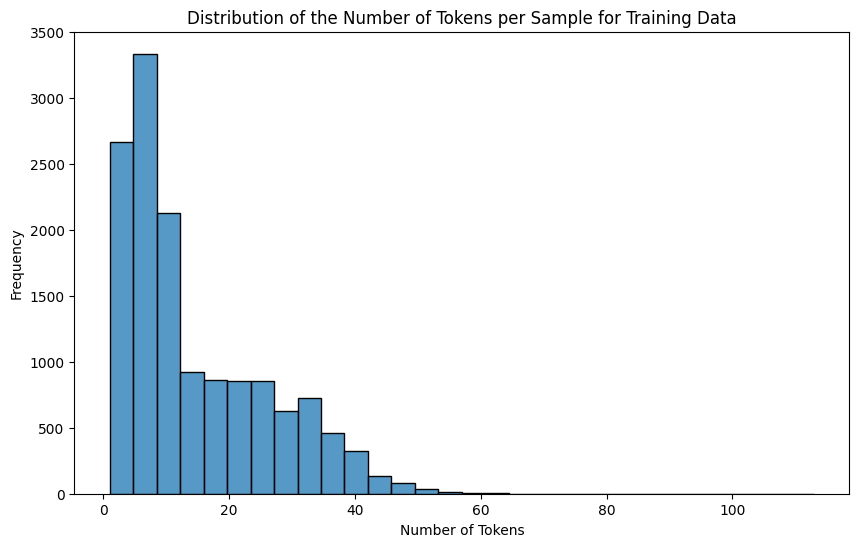

In [ ]:
# Plot the distribution of the number of tokens per sample
plt.figure(figsize=(10, 6))
sns.histplot(tokens_per_sample, bins=30)
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.title("Distribution of the Number of Tokens per Sample for Training Data")
plt.show()

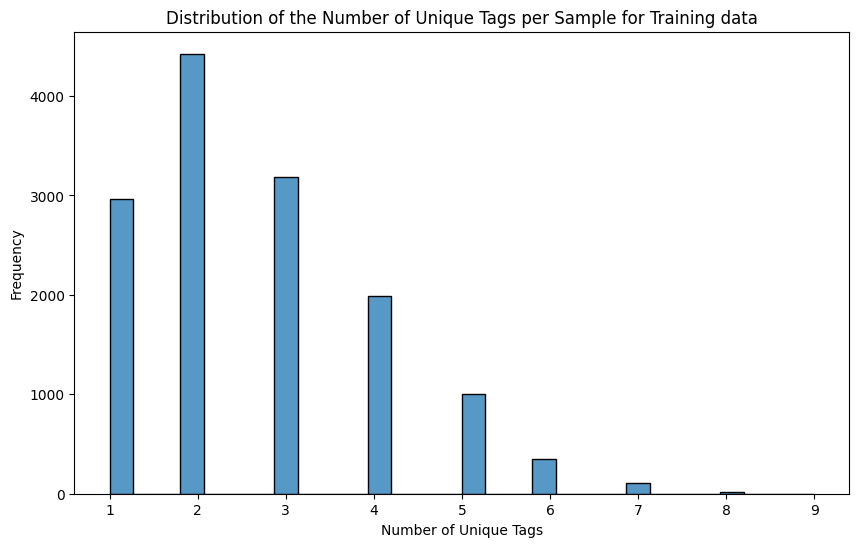

In [ ]:
# Plot the distribution of the number of unique tags per sample
plt.figure(figsize=(10, 6))
sns.histplot([len(set([tag for _, tag in sentence])) for sentence in train_samples], bins=30)
plt.xlabel("Number of Unique Tags")
plt.ylabel("Frequency")
plt.title("Distribution of the Number of Unique Tags per Sample for Training data")
plt.show()

In [ ]:
# Print the results
print(f"Number of samples: {num_samples}")
print(f"Number of unique tags: {num_unique_tags}")
print(f"Average number of tokens per sample: {avg_tokens_per_sample}")

Number of samples: 14041
Number of unique tags: 9
Average number of tokens per sample: 14.501887329962253


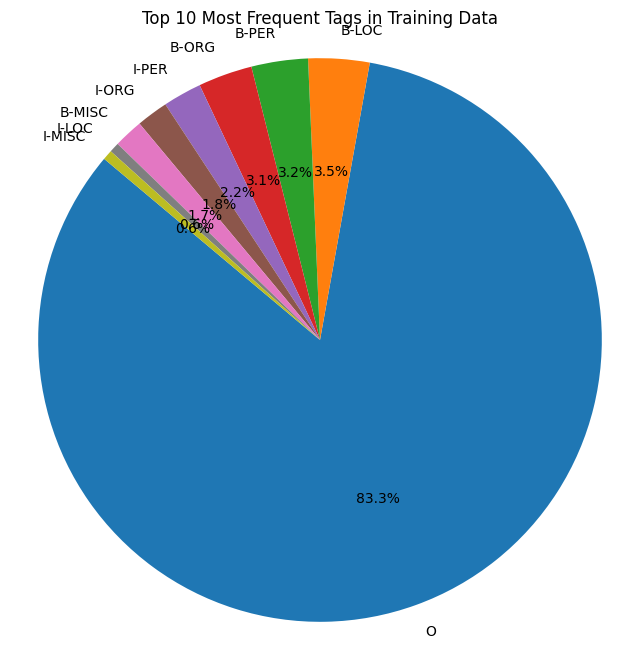

In [ ]:
# Calculate the frequency of each tag in the test dataset
tag_freq = {}
for sentence in train_samples:
    for _, tag in sentence:
        tag_freq[tag] = tag_freq.get(tag, 0) + 1

# Sort the tags by frequency
sorted_tags = sorted(tag_freq.items(), key=lambda x: x[1], reverse=True)

# Extract the top N tags and their frequencies for the pie chart
top_tags = [tag for tag, freq in sorted_tags[:10]]
top_freq = [freq for tag, freq in sorted_tags[:10]]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_freq, labels=top_tags, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Most Frequent Tags in Training Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

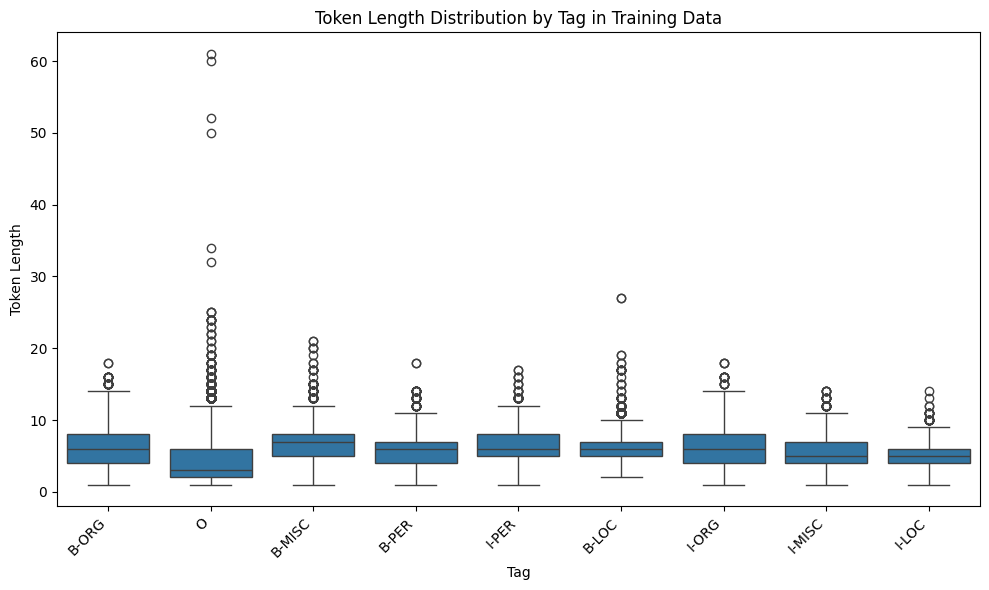

In [ ]:
# Create a new DataFrame to store token lengths and corresponding tags
token_lengths = []
tags = []
for sentence in train_samples:
    for token, tag in sentence:
        token_lengths.append(len(token))
        tags.append(tag)
df_boxplot = pd.DataFrame({'Token Length': token_lengths, 'Tag': tags})

# Plot box plots for token lengths grouped by tags
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot, x='Tag', y='Token Length')
plt.xlabel('Tag')
plt.ylabel('Token Length')
plt.title('Token Length Distribution by Tag in Training Data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**TESTING DATA**

In [ ]:
#perform EDA on the test samples data
import seaborn as sns
import matplotlib.pyplot as plt

# Get the number of samples in the train dataset
num_samples = len(test_samples)

# Get the number of unique tags in the train dataset
unique_tags = set([tag for sentence in train_samples for _, tag in sentence])
num_unique_tags = len(unique_tags)

# Get the average number of tokens per sample in the train dataset
tokens_per_samplet = [len(sentence) for sentence in test_samples]
avg_tokens_per_samplet = sum(tokens_per_sample) / len(tokens_per_sample)

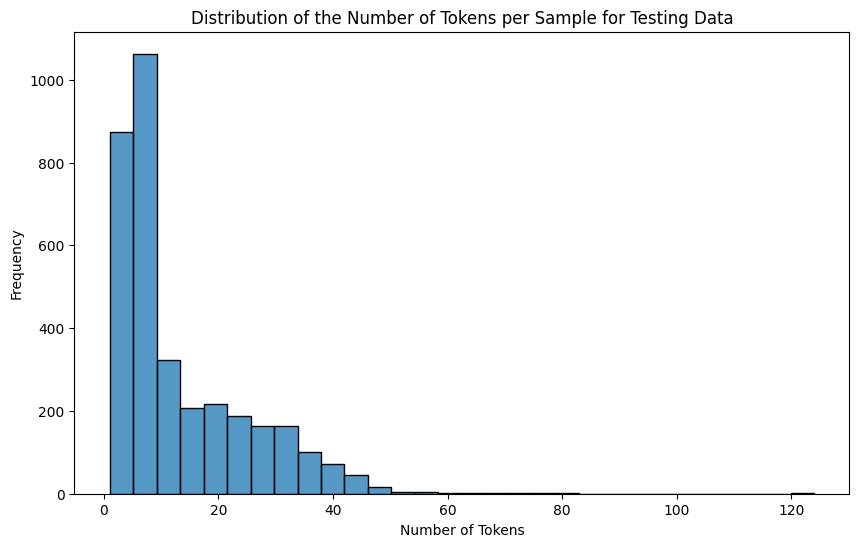

In [ ]:
# Plot the distribution of the number of tokens per sample
plt.figure(figsize=(10, 6))
sns.histplot(tokens_per_samplet, bins=30)
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.title("Distribution of the Number of Tokens per Sample for Testing Data")
plt.show()

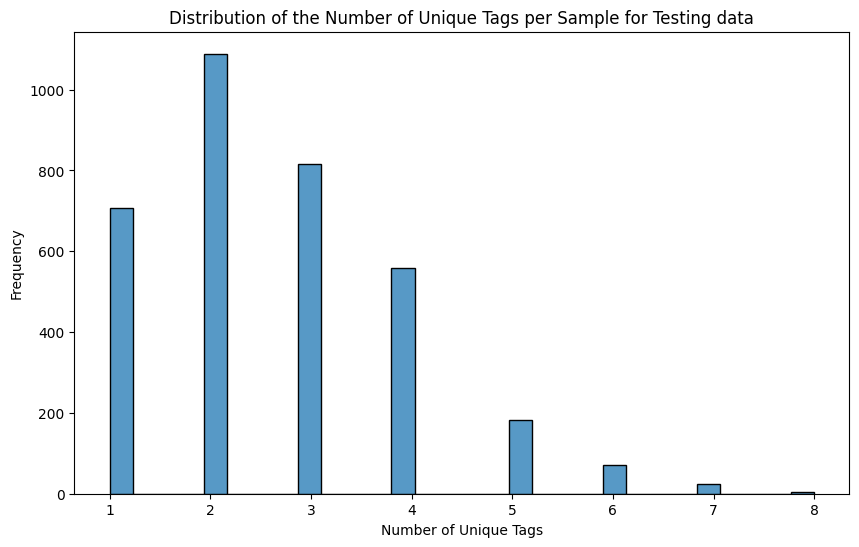

In [ ]:
# Plot the distribution of the number of unique tags per sample
plt.figure(figsize=(10, 6))
sns.histplot([len(set([tag for _, tag in sentence])) for sentence in test_samples], bins=30)
plt.xlabel("Number of Unique Tags")
plt.ylabel("Frequency")
plt.title("Distribution of the Number of Unique Tags per Sample for Testing data")
plt.show()

In [ ]:
# Print the results
print(f"Number of samples: {num_samples}")
print(f"Number of unique tags: {num_unique_tags}")
print(f"Average number of tokens per sample: {avg_tokens_per_samplet}")

Number of samples: 3453
Number of unique tags: 9
Average number of tokens per sample: 13.447726614538082


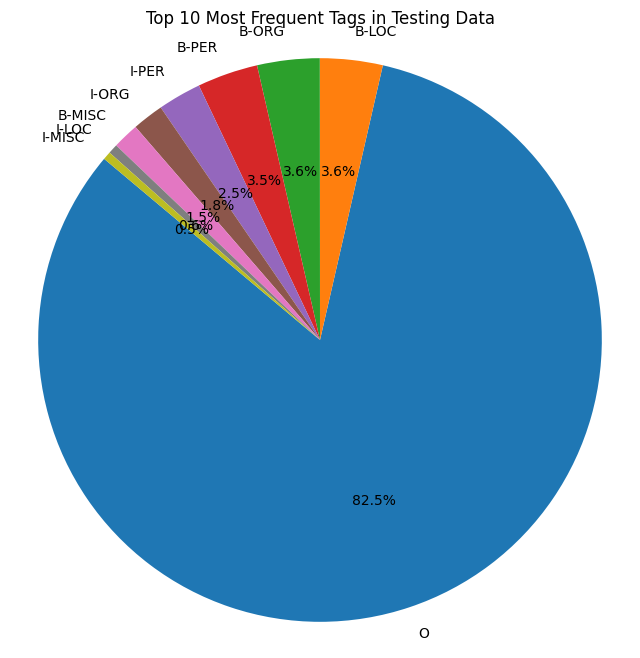

In [ ]:
# Calculate the frequency of each tag in the test dataset
tag_freq = {}
for sentence in test_samples:
    for _, tag in sentence:
        tag_freq[tag] = tag_freq.get(tag, 0) + 1

# Sort the tags by frequency
sorted_tags = sorted(tag_freq.items(), key=lambda x: x[1], reverse=True)

# Extract the top N tags and their frequencies for the pie chart
top_tags = [tag for tag, freq in sorted_tags[:10]]
top_freq = [freq for tag, freq in sorted_tags[:10]]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_freq, labels=top_tags, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Most Frequent Tags in Testing Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

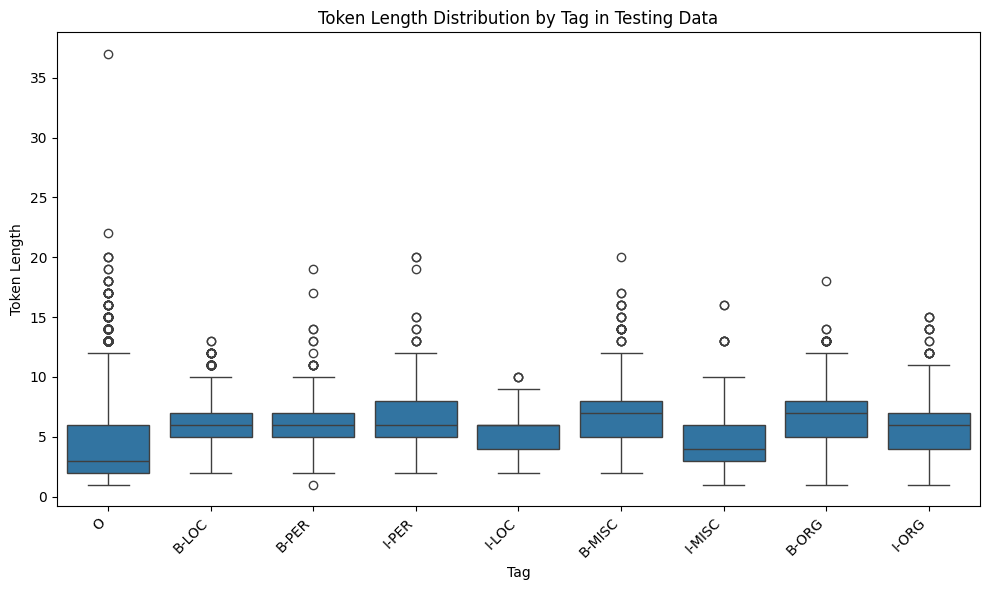

In [ ]:
# Create a new DataFrame to store token lengths and corresponding tags
token_lengths = []
tags = []
for sentence in test_samples:
    for token, tag in sentence:
        token_lengths.append(len(token))
        tags.append(tag)
df_boxplot = pd.DataFrame({'Token Length': token_lengths, 'Tag': tags})

# Plot box plots for token lengths grouped by tags
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot, x='Tag', y='Token Length')
plt.xlabel('Tag')
plt.ylabel('Token Length')
plt.title('Token Length Distribution by Tag in Testing Data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


**VALID DATA**

In [ ]:
#perform EDA on the test valid data
import seaborn as sns
import matplotlib.pyplot as plt

# Get the number of samples in the train dataset
num_samples = len(valid_samples)

# Get the number of unique tags in the train dataset
unique_tags = set([tag for sentence in valid_samples for _, tag in sentence])
num_unique_tags = len(unique_tags)

# Get the average number of tokens per sample in the train dataset
tokens_per_samplev = [len(sentence) for sentence in valid_samples]
avg_tokens_per_samplev = sum(tokens_per_samplev) / len(tokens_per_samplev)

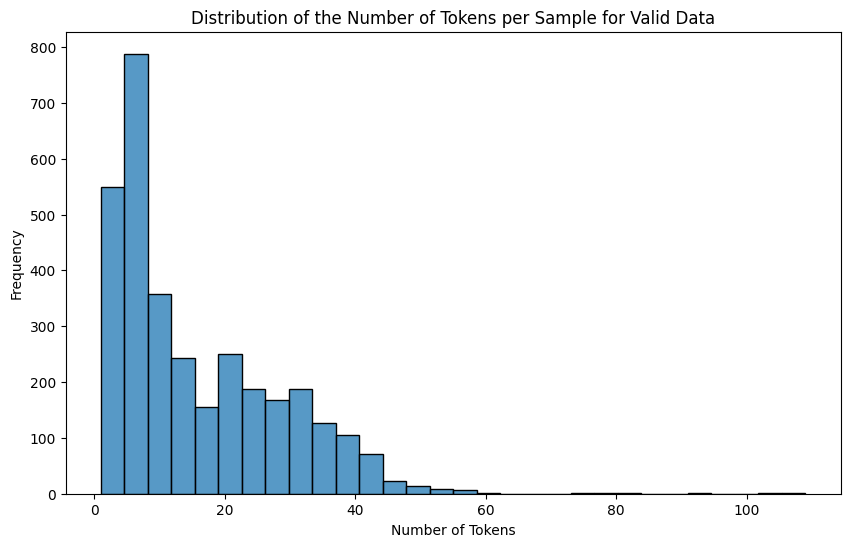

In [ ]:
# Plot the distribution of the number of tokens per sample
plt.figure(figsize=(10, 6))
sns.histplot(tokens_per_samplev, bins=30)
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.title("Distribution of the Number of Tokens per Sample for Valid Data")
plt.show()

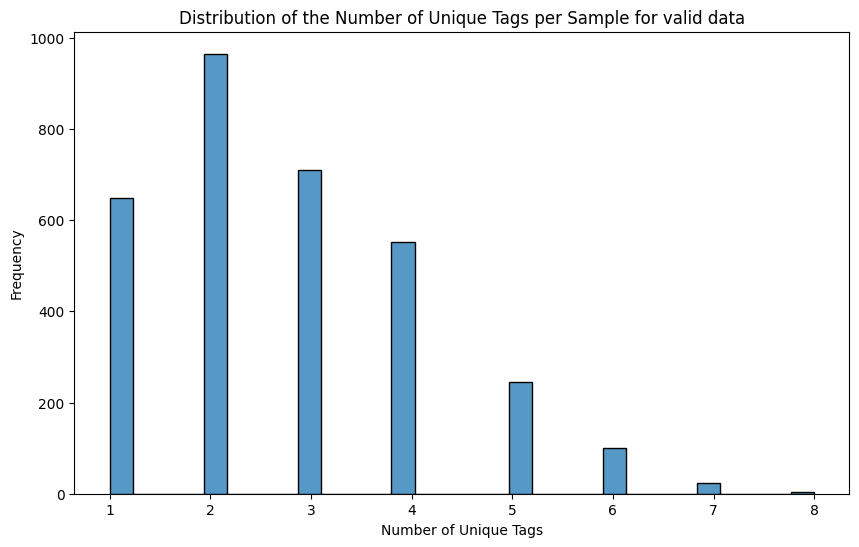

In [ ]:
# Plot the distribution of the number of unique tags per sample
plt.figure(figsize=(10, 6))
sns.histplot([len(set([tag for _, tag in sentence])) for sentence in valid_samples], bins=30)
plt.xlabel("Number of Unique Tags")
plt.ylabel("Frequency")
plt.title("Distribution of the Number of Unique Tags per Sample for valid data")
plt.show()

In [ ]:
# Print the results
print(f"Number of samples: {num_samples}")
print(f"Number of unique tags: {num_unique_tags}")
print(f"Average number of tokens per sample: {avg_tokens_per_samplev}")

Number of samples: 3250
Number of unique tags: 9
Average number of tokens per sample: 15.803692307692307


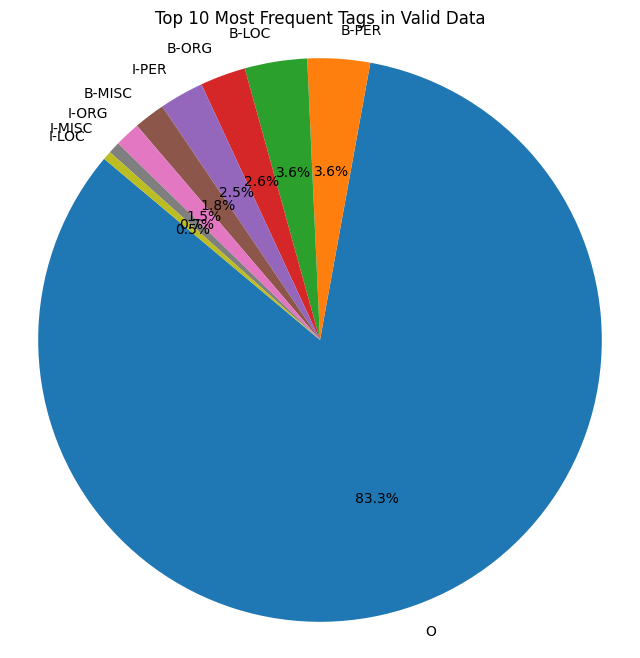

In [ ]:
# Calculate the frequency of each tag in the valid dataset
tag_freq = {}
for sentence in valid_samples:
    for _, tag in sentence:
        tag_freq[tag] = tag_freq.get(tag, 0) + 1

# Sort the tags by frequency
sorted_tags = sorted(tag_freq.items(), key=lambda x: x[1], reverse=True)

# Extract the top N tags and their frequencies for the pie chart
top_tags = [tag for tag, freq in sorted_tags[:10]]
top_freq = [freq for tag, freq in sorted_tags[:10]]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_freq, labels=top_tags, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Most Frequent Tags in Valid Data")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

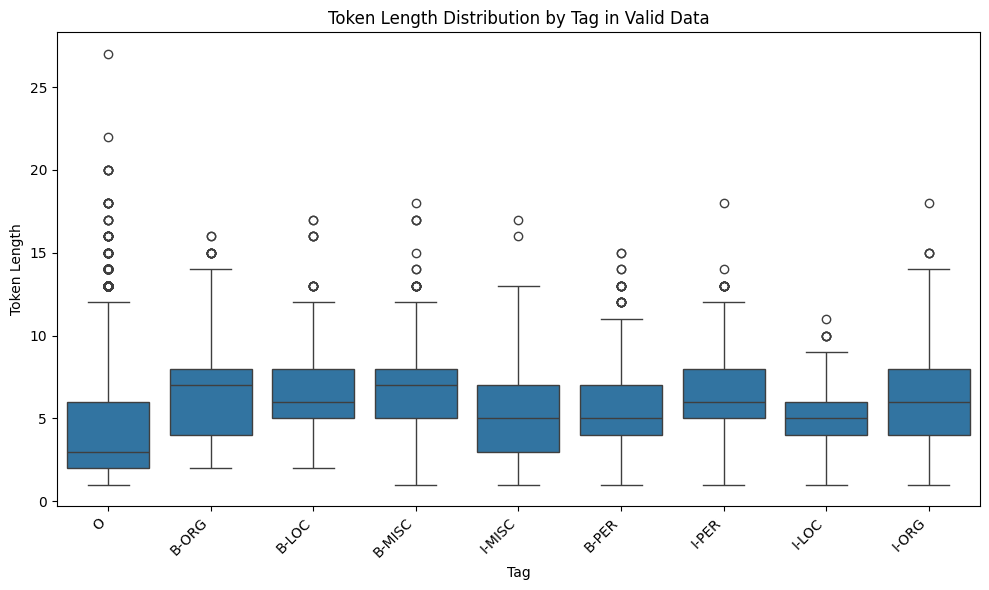

In [ ]:
# Create a new DataFrame to store token lengths and corresponding tags
token_lengths = []
tags = []
for sentence in valid_samples:
    for token, tag in sentence:
        token_lengths.append(len(token))
        tags.append(tag)
df_boxplot = pd.DataFrame({'Token Length': token_lengths, 'Tag': tags})

# Plot box plots for token lengths grouped by tags
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot, x='Tag', y='Token Length')
plt.xlabel('Tag')
plt.ylabel('Token Length')
plt.title('Token Length Distribution by Tag in Valid Data')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**EVALUATION METRICS**

In [69]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# assignment for NER evaluation
true_tags = ['O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O']
predicted_tags = ['O', 'B-PER', 'I-PER', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O']

# Assign true tags and predicted tags for evaluation
true_tags = [tag for tags in true_tags_list for tag in tags]
predicted_tags = [tag for tags in predicted_tags_list for tag in tags]

In [70]:
# Convert the tags to numerical labels for evaluation (assuming you have a label encoder)
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(np.array(true_tags).flatten())
y_pred = label_encoder.transform(np.array(predicted_tags).flatten())

In [71]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8889
Precision: 0.7963
Recall: 0.8889
F1-score: 0.8384


**CONFUSION MATRIX**

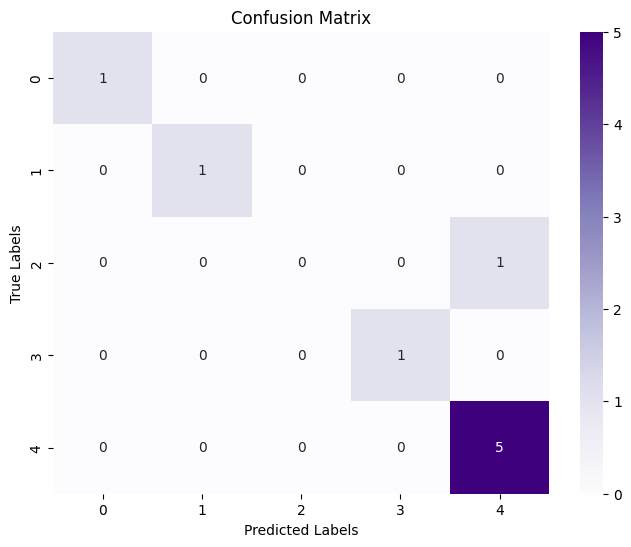

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()